# Dog Breed Image Classification Using AWS SageMaker

This project demonstrate the skills and tools acquired in AWS. In this project, Will be using `AWS Sagemaker` to finetune a pretrained model that can perform image classification. Will use `Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices` to finish this project. The dataset is the dog breed classication dataset to classify between different breeds of dogs in images.

## Dataset & Project
The dataset contains images from 133 dog breeds divided into training, testing and validation datasets. Using the `ResNet50 model` to perform `transfer learning` on a dataset. Once trained the model (using hyperparameter tuning), will deploy the model to a `Sagemaker Endpoint`. Testing deployment, by query the deployed model with a sample image and get a prediction.

As a ML Engineer, tracking and coordinating the flow of data (images, models, metrics etc) through these different steps with the `main goal of setting up an infrastructure that enables other developers to train such models` beside having an accurate trained model.

In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'


In [ ]:
! conda update Flask Jinja2 MarkupSafe --yes -q

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


In [ ]:
! pip -q uninstall Werkzeug jinja2 --yes

Keyring is skipped due to an exception: 'keyring.backends'


In [ ]:
! pip -q install jinja2==3.0 Werkzeug==2.0.0 

Keyring is skipped due to an exception: 'keyring.backends'


In [ ]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

In [ ]:
import os
from sagemaker.tuner import ContinuousParameter, CategoricalParameter, IntegerParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch


In [ ]:
from sagemaker import get_execution_role


In [ ]:
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile


In [ ]:
from smdebug.trials import create_trial

[2023-02-02 10:12:32.372 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:2564 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [ ]:
from smdebug.core.modes import ModeKeys

In [ ]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

In [ ]:
import IPython

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

from PIL import Image
import io

import numpy as np

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-02 08:50:06--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.160
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  28.5MB/s    in 28s     

2023-02-02 08:50:35 (39.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [ ]:
sess = sagemaker.Session()
bucket = sess.default_bucket()  

os.environ["DEFAULT_S3_BUCKET"] = bucket

In [ ]:
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/ --quiet

In [ ]:
! aws s3 ls  s3://${DEFAULT_S3_BUCKET}/dogImages/

                           PRE test/
                           PRE train/
                           PRE valid/


In [ ]:
num_features_train = len(os.listdir("dogImages/train/"))
print(num_features_train)
num_features_test = len(os.listdir("dogImages/test/"))
print(num_features_test)
num_features_valid = len(os.listdir("dogImages/valid/"))
print(num_features_valid)

133
133
133


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges={
    "lr":ContinuousParameter(0.001, 0.1),
    "batch_size":CategoricalParameter([4,8,16,32]),
    "epochs": IntegerParameter(2, 5)
}

session = sagemaker.Session()
bucket = session.default_bucket()
region =session.boto_region_name
role = get_execution_role()

In [ ]:
print("Default Session: {}".format(session))
print("Default Bucket : {}".format(bucket))
print("AWS Region     : {}".format(region))
print("RoleArn        : {}".format(role))

Default Session: <sagemaker.session.Session object at 0x7f47e6872cd0>
Default Bucket : sagemaker-us-east-1-933845045900
AWS Region     : us-east-1
RoleArn        : arn:aws:iam::933845045900:role/service-role/AmazonSageMaker-ExecutionRole-20230130T210045


In [ ]:
os.environ['SM_MODEL_DIR'] = 's3://'+bucket+'/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://'+bucket+'/output/'

In [ ]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point='hpo.py',
    py_version='py36',
    base_job_name='hpo_tuning',
    role=role,
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.m5.large')

In [ ]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [ ]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type='Auto')


In [ ]:
s3_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

In [ ]:
print(s3_data)
print(s3_output_dir)
print(s3_model_dir)

s3://sagemaker-us-east-1-933845045900/dogImages/
s3://sagemaker-us-east-1-933845045900/output/
s3://sagemaker-us-east-1-933845045900/model/


In [ ]:
os.environ['SM_CHANNEL_TRAIN']= s3_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({'train' : s3_data},wait=True)  # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [ ]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-02-02 11:24:17 Starting - Found matching resource for reuse
2023-02-02 11:24:17 Downloading - Downloading input data
2023-02-02 11:24:17 Training - Training image download completed. Training in progress.
2023-02-02 11:24:17 Uploading - Uploading generated training model
2023-02-02 11:24:17 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"16"',
 'epochs': '4',
 'lr': '0.020044974840352555',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning-2023-02-02-10-14-12-579"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-933845045900/hpo_tuning-2023-02-02-10-14-12-579/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

collection_configs = [CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

# Profiler Setup
profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1))
# Debugger Setup
debugger_config = DebuggerHookConfig(collection_configs=collection_configs)

In [ ]:
# TODO: Create and fit an estimator

hyperparameters = {"batch_size": "4", "epochs":"2", "lr": "0.005374899793978716"}

estimator_train = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

In [ ]:
estimator_train.fit({'train' : s3_data},wait=True)

2023-02-02 12:55:21 Starting - Starting the training job...
2023-02-02 12:55:52 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2023-02-02 12:57:12 Downloading - Downloading input data......
2023-02-02 12:58:13 Training - Downloading the training image..................
2023-02-02 13:01:14 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-02 13:01:29,220 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-02 13:01:29,248 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-02 13:01:29,251 sagemaker_pytorch_container.training INFO     Invoking user training

In [ ]:
# TODO: Plot a debugging output.
training_job_name = estimator_train.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator_train.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator_train.output_path + estimator_train.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

Training jobname: pytorch-training-2023-02-02-12-55-20-920
Region: us-east-1
[2023-02-02 13:11:30.456 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:2564 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-933845045900/pytorch-training-2023-02-02-12-55-20-920/debug-output
[2023-02-02 13:11:31.312 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:2564 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 235 more expected)', IncompleteRead(0 bytes read, 235 more expected)) while reading s3://sagemaker-us-east-1-933845045900/pytorch-training-2023-02-02-12-55-20-920/debug-output/index/000000000/000000000000_worker_0.json . Will retry now
[2023-02-02 13:11:40.804 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:2564 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-02 13:11:41.828 datascience-1-0-m

You will find the profiler report in s3://sagemaker-us-east-1-933845045900/pytorch-training-2023-02-02-12-55-20-920/rule-output


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

* Import package issues which resolved in the notebook first by doing pip uninstall Werkzeug jinja2 && pip install jinja2==3.0 Werkzeug==2.0.0.
* Observed error in model execution and updated the train_model.py line number according to the error log

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

* In case there was an error in the parameter passed then I couuld observe the log and verify

In [ ]:
# TODO: Display the profiler output

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive



2023-02-02 13:06:31     423597 pytorch-training-2023-02-02-12-55-20-920/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-02 13:06:31     280058 pytorch-training-2023-02-02-12-55-20-920/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-02 13:06:26        558 pytorch-training-2023-02-02-12-55-20-920/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-02 13:06:26       7927 pytorch-training-2023-02-02-12-55-20-920/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-02 13:06:26       2211 pytorch-training-2023-02-02-12-55-20-920/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-02 13:06:26        130 pytorch-training-2023-02-02-12-55-20-920/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-02 13:06:26        918 pytorch-training-2023-02-02-12-55-20-920/rule-output/ProfilerReport/profiler-output/profiler-re

In [ ]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator_train.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
estimator_train.model_data

's3://sagemaker-us-east-1-933845045900/pytorch-training-2023-02-02-12-55-20-920/output/model.tar.gz'

In [ ]:
# TODO: Deploy your model to an endpoint
model_location=estimator_train.model_data

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [ ]:
# TODO: Add your deployment configuration like instance type and number of instances
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor) 

In [ ]:
predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.g4dn.xlarge") 

----------!

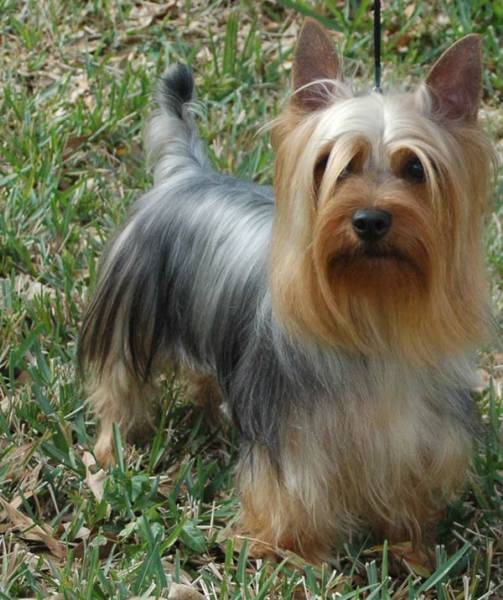

In [ ]:
# TODO: Run an prediction on the endpoint
with open("./dogImages/test/127.Silky_terrier/Silky_terrier_08040.jpg", "rb") as f: 
    image = f.read()
Image.open(io.BytesIO(image))


In [ ]:
# TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
np.argmax(response, 1) + 1

array([127])

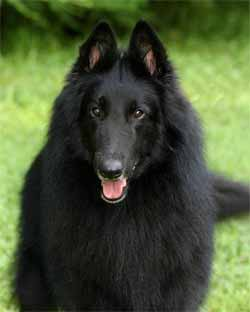

In [ ]:
# code to load and preprocess image to send to endpoint for prediction
img_file_name = "dogImages/train/021.Belgian_sheepdog/Belgian_sheepdog_01477.jpg"
with open(img_file_name, "rb") as f:
    image1 = f.read()
    
type(image1)

from PIL import Image
import io
Image.open(io.BytesIO(image1))

In [ ]:
response1 = predictor.predict(image1)

In [ ]:
np.argmax(response1, 1)

array([20])

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()